# Documentație Proiect Big Data

## 1. Introducere

### a. Prezentarea succintă a setului de date

Setul de date utilizat poate fi accesat pe https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset și este reprezentat de un fișier de tip csv care conține caracteristici referitoare la starea de sănătate a unor indivizi, detalii personale ale acestora, precum și dacă au suferit un infarct sau nu. Acest set de date prezintă 12 coloane și conține 1350 de observații, având următoarea structură:
-	id: identificator unic
-	gender: "Male", "Female" sau "Other"
-	age: vârsta individului
-	hypertension: 0 sau 1
-	heart_disease: 0 sau 1
-	ever_married: "No" sau "Yes"
-	work_type: "children", "Govt_jov", "Never_worked", "Private" sau "Self-employed"
-	Residence_type: "Rural" sau "Urban"
-	avg_glucose_level: valoarea medie a glucozei din sânge
-	bmi: indicele de masă corporală
-	smoking_status: "formerly smoked", "never smoked", "smokes" sau "Unknown"
-	stroke: 0 sau 1


### b. Enunțarea obiectivelor

Dupa curățarea și pregătirea datelor, vom utiliza diverse metode de clasificare și regresie.
Folosind două metode de clasificare din Spark MLib, vom prezice daca indivizii analizați au sau nu probleme cu inima, iar folosind o metodă de regresie vom încerca să prezicem care este vârsta acestora în funcție de celelalte caracteristici.
Pentru a prezice dacă un individ va avea sau nu un infarct, vom folosi o metodă de deep learning din Tensorflow.


## 2.Pregătirea, curățarea și transformarea datelor

În primul rând, vom genera o sesiune Spark și vom crea un dataframe cu datele din fișierul de intrare, după care vom afișa schema datelor.

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import mean
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline
from pyspark.sql.functions import corr
from pyspark.sql.functions import col
stroke_data_file = "Data/stroke-data.csv"

# create a spark session and read the data from the csv file
spark = SparkSession.builder.appName('Heart Disease Prediction').getOrCreate()

print("READING THE INPUT FILE")

df = spark.read.csv(stroke_data_file, inferSchema=True, header=True)

# display the schema and the first rows from the dataframe
df.printSchema()


READING THE INPUT FILE
root
 |-- id: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: double (nullable = true)
 |-- hypertension: integer (nullable = true)
 |-- heart_disease: integer (nullable = true)
 |-- ever_married: string (nullable = true)
 |-- work_type: string (nullable = true)
 |-- Residence_type: string (nullable = true)
 |-- avg_glucose_level: double (nullable = true)
 |-- bmi: string (nullable = true)
 |-- smoking_status: string (nullable = true)
 |-- stroke: integer (nullable = true)



Vom afișa primele intrări din dataframe, precum și statistici despre setul de date.

In [2]:
print("DISPLAY THE FIRST ROWS FROM THE DATAFRAME\n")
df.show(10)


DISPLAY THE FIRST ROWS FROM THE DATAFRAME

+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
|   id|gender| age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level| bmi| smoking_status|stroke|
+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
| 9046|  Male|67.0|           0|            1|         Yes|      Private|         Urban|           228.69|36.6|formerly smoked|     1|
|51676|Female|61.0|           0|            0|         Yes|Self-employed|         Rural|           202.21| N/A|   never smoked|     1|
|31112|  Male|80.0|           0|            1|         Yes|      Private|         Rural|           105.92|32.5|   never smoked|     1|
|60182|Female|49.0|           0|            0|         Yes|      Private|         Urban|           171.23|34.4|         smokes|     1|
| 1665|Femal

In [3]:
print("DISPLAY STATISTICS\n")

# display statistics about the dataset
df.describe().show()


DISPLAY STATISTICS

+-------+-----------------+------+------------------+-------------------+-------------------+------------+---------+--------------+------------------+------------------+--------------+-------------------+
|summary|               id|gender|               age|       hypertension|      heart_disease|ever_married|work_type|Residence_type| avg_glucose_level|               bmi|smoking_status|             stroke|
+-------+-----------------+------+------------------+-------------------+-------------------+------------+---------+--------------+------------------+------------------+--------------+-------------------+
|  count|             1349|  1349|              1349|               1349|               1349|        1349|     1349|          1349|              1349|              1349|          1349|               1349|
|   mean|36312.73610081542|  null| 46.94315789473684|0.12157153446997776|0.07190511489992588|        null|     null|          null|110.13786508524811|29.5877055

Afișăm distribuția categoriilor pentru fiecare variabilă categorială, după care le transformăm folosind StringIndexer.

In [4]:
print("DISPLAY CATEGORICAL VARIABLES COUNT\n")

df.groupBy('gender').count().show()
df.groupBy('ever_married').count().show()
df.groupBy('work_type').count().show()
df.groupBy('Residence_type').count().show()
df.groupBy('smoking_status').count().show()


DISPLAY CATEGORICAL VARIABLES COUNT

+------+-----+
|gender|count|
+------+-----+
|Female|  795|
|  Male|  554|
+------+-----+

+------------+-----+
|ever_married|count|
+------------+-----+
|          No|  416|
|         Yes|  933|
+------------+-----+

+-------------+-----+
|    work_type|count|
+-------------+-----+
| Never_worked|    5|
|Self-employed|  230|
|      Private|  811|
|     children|  142|
|     Govt_job|  161|
+-------------+-----+

+--------------+-----+
|Residence_type|count|
+--------------+-----+
|         Urban|  667|
|         Rural|  682|
+--------------+-----+

+---------------+-----+
| smoking_status|count|
+---------------+-----+
|         smokes|  202|
|        Unknown|  369|
|   never smoked|  530|
|formerly smoked|  248|
+---------------+-----+



In [5]:
# transform relevant columns containing string values into categorical variables using StringIndexer
columns_to_transform = [
    "gender",
    "ever_married",
    "work_type",
    "Residence_type",
    "smoking_status"
]

indexers = []
for column in columns_to_transform:
    indexers.append(StringIndexer(inputCol=column, outputCol=column + "_cat"))


Aplicăm următoarele operații:
-	Transformăm coloana bmi din string în double
-	Ștergem înregistrările în care valoarea lui bmi este null sau smoking_status este Unknown
-	Completăm valorile lipsă ale lui bmi cu media de pe coloana respectivă
-	Ștergem coloana id, deoarece nu ne este de folos

In [6]:
print("CLEANING THE DATA")

# cast columns containing numeric values (but provided as string) to double ('bmi')
df = df.withColumn("bmi", df["bmi"].cast("double"))

# remove the rows where bmi is null and smoking_status is unknown
df = df.filter((col("bmi").isNotNull()) | (col("smoking_status") != "Unknown"))

# fill the unknown bmi values with the mean value
df = df.na.fill(df.select(mean(df["bmi"])).collect()[0][0], ["bmi"])

# drop irrelevant columns ('id')
df = df.drop("id")


CLEANING THE DATA


## 3. Aplicarea a cel puțin două metode ML

### Metode de clasificare
Prin intermediul metodelor de clasificare dorim să prezicem dacă un individ are sau nu probleme cu inima.
Folosind un VectorAssembler vom asambla coloanele relevante din dataframe într-un vector denumit features. Deoarece dorim să prezicem dacă un individ are sau nu probleme cu inima, vom exclude această coloană, precum și id-ul, care este irelevant, iar pentru variabilele categoriale vom folosi sufixul _cat, așa cum a fost precizat în StringIndexer.

In [7]:
# assemble the relevant columns in a vector of features for classification
assembler = VectorAssembler(
    inputCols=[
        "gender_cat",
        "age",
        "hypertension",
        "stroke",
        "ever_married_cat",
        "work_type_cat",
        "Residence_type_cat",
        "avg_glucose_level",
        "bmi",
        "smoking_status_cat"
    ],
    outputCol="features")


Vom crea un pipeline cu indexerii definiți anterior și cu assembler-ul, pe care îl vom antrena și vom obține dataframe-ul în forma dorită.

In [8]:
print("CREATE A PIPELINE WITH THE INDEXERS AND ASSEMBLER\n")

# create a Pipeline with the previously defined indexers and assembler
pipeline = Pipeline(stages=[*indexers, assembler])

# train the pipeline
output = pipeline.fit(df).transform(df)

CREATE A PIPELINE WITH THE INDEXERS AND ASSEMBLER



Vom afișa coloanele features și heart_disease din dataframe-ul obținut.

In [9]:
# display 'features' and 'heart_disease' columns
print("DISPLAY 'features' AND 'heart_disease' COLUMNS")
output.select("features", "heart_disease").show()

DISPLAY 'features' AND 'heart_disease' COLUMNS
+--------------------+-------------+
|            features|heart_disease|
+--------------------+-------------+
|[1.0,67.0,0.0,1.0...|            1|
|(10,[1,3,5,7,8],[...|            0|
|(10,[0,1,3,7,8],[...|            1|
|[0.0,49.0,0.0,1.0...|            0|
|[0.0,79.0,1.0,1.0...|            0|
|[1.0,81.0,0.0,1.0...|            0|
|[1.0,74.0,1.0,1.0...|            1|
|[0.0,69.0,0.0,1.0...|            0|
|[0.0,78.0,0.0,1.0...|            0|
|(10,[1,2,3,7,8],[...|            0|
|[0.0,61.0,0.0,1.0...|            1|
|[0.0,54.0,0.0,1.0...|            0|
|(10,[1,3,6,7,8],[...|            1|
|[0.0,50.0,1.0,1.0...|            0|
|[1.0,64.0,0.0,1.0...|            1|
|[1.0,75.0,1.0,1.0...|            0|
|[0.0,60.0,0.0,1.0...|            0|
|[0.0,71.0,0.0,1.0...|            0|
|[0.0,52.0,1.0,1.0...|            0|
|[0.0,79.0,0.0,1.0...|            0|
+--------------------+-------------+
only showing top 20 rows



Divizăm dataframe-ul în date de antrenament (70%) și date de testare (30%).

In [10]:
final_data = output.select("features", "heart_disease")

# divide the dataset into train and test subsets
train_data, test_data = final_data.randomSplit([0.7, 0.3])

Vom aplica două metode de clasificare, anume DecisionTreeClassifier și RandomForestClassifier, pentru a prezice dacă indivizii au sau nu probleme cu inima.
Vom antrena modelul DecisionTreeClassifier și vom afișa acuratețea acestuia.

In [11]:
# Use decision tree classifier
dt = DecisionTreeClassifier(labelCol="heart_disease", featuresCol="features")
dt_model = dt.fit(train_data)

predictions = dt_model.transform(test_data)
evaluator = MulticlassClassificationEvaluator(
    predictionCol="prediction", labelCol="heart_disease", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("DECISION TREE CLASSIFIER ACCURACY: ", accuracy)

DECISION TREE CLASSIFIER ACCURACY:  0.9212598425196851


Tot cu scopul de a prezice dacă indivizii au probleme cu inima, vom antrena un model de RandomForestClassifier și vom afișa acuratețea acestuia.

In [12]:
# Use random forest classifier
rf = RandomForestClassifier(labelCol="heart_disease", featuresCol="features", numTrees=10)
rf_model = rf.fit(train_data)

predictions = rf_model.transform(test_data)
evaluator = MulticlassClassificationEvaluator(
    predictionCol="prediction", labelCol="heart_disease", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("RANDOM FOREST CLASSIFIER ACCURACY: ", accuracy)

RANDOM FOREST CLASSIFIER ACCURACY:  0.9501312335958005


### Metode de regresie

Cu scopul de a prezice vârsta unui individ în funcție de celelalte caracteristici, am folosit metoda de regresie LinearRegression. 
Folosind un alt VectorAssembler vom asambla coloanele relevante din dataframe într-un vector denumit features. Deoarece dorim să prezicem vârsta unui individ, vom exclude această coloană, precum și id-ul, care este irelevant, iar pentru variabilele categoriale vom folosi sufixul _cat, așa cum a fost precizat în StringIndexer.


In [13]:
# assemble the relevant columns in a vector of features for regression
assembler = VectorAssembler(
    inputCols=[
        "gender_cat",
        "hypertension",
        "heart_disease",
        "ever_married_cat",
        "work_type_cat",
        "Residence_type_cat",
        "avg_glucose_level",
        "bmi",
        "smoking_status_cat",
        "stroke"
    ],
    outputCol="features")

Vom crea un nou pipeline cu indexerii definiți anterior și cu noul assembler-ul, pe care îl vom antrena și vom obține dataframe-ul în forma dorită.

In [14]:
print("CREATE A PIPELINE WITH THE INDEXERS AND ASSEMBLER\n")

pipeline = Pipeline(stages=[*indexers, assembler])
output = pipeline.fit(df).transform(df)

CREATE A PIPELINE WITH THE INDEXERS AND ASSEMBLER



Vom afișa coloanele features și age din dataframe-ul obținut.

In [15]:
# display 'features' and 'age' columns
print("DISPLAY 'features' AND 'age' COLUMNS")
output.select("features", "age").show()

DISPLAY 'features' AND 'age' COLUMNS
+--------------------+----+
|            features| age|
+--------------------+----+
|[1.0,0.0,1.0,0.0,...|67.0|
|(10,[4,6,7,9],[1....|61.0|
|(10,[0,2,6,7,9],[...|80.0|
|(10,[5,6,7,8,9],[...|49.0|
|(10,[1,4,6,7,9],[...|79.0|
|[1.0,0.0,0.0,0.0,...|81.0|
|[1.0,1.0,1.0,0.0,...|74.0|
|(10,[3,5,6,7,9],[...|69.0|
|(10,[5,6,7,8,9],[...|78.0|
|(10,[1,6,7,9],[1....|81.0|
|[0.0,0.0,1.0,0.0,...|61.0|
|(10,[5,6,7,8,9],[...|54.0|
|(10,[2,5,6,7,9],[...|79.0|
|(10,[1,4,6,7,9],[...|50.0|
|[1.0,0.0,1.0,0.0,...|64.0|
|[1.0,1.0,0.0,0.0,...|75.0|
|(10,[3,5,6,7,9],[...|60.0|
|(10,[4,6,7,8,9],[...|71.0|
|[0.0,1.0,0.0,0.0,...|52.0|
|(10,[4,5,6,7,9],[...|79.0|
+--------------------+----+
only showing top 20 rows



Divizăm dataframe-ul în date de antrenament (70%) și date de testare (30%).

In [16]:
final_data = output.select("features", "age")

# divide the dataset into train and test subsets
train_data, test_data = final_data.randomSplit([0.7, 0.3])

Antrenăm un model de LinearRegression și evaluăm rezultatele.

In [17]:
lr = LinearRegression(labelCol="age", predictionCol="prediction", regParam=0.1)
lr_model = lr.fit(train_data)

# evaluate the model
test_results = lr_model.evaluate(test_data)

# display evaluation results
print("REGRESSION RESULTS\n")
print("RMSE: {}".format(test_results.rootMeanSquaredError))
print("MSE: {}".format(test_results.meanSquaredError))
print("R2: {}".format(test_results.r2))

REGRESSION RESULTS

RMSE: 14.935503934913239
MSE: 223.06927778980887
R2: 0.5452015708215026


Afișăm corelația dintre coloana age și alte coloane.

In [18]:
# Display the correlation between age and other columns
print("\nDISPLAY CORRELATIONS BETWEEN 'age' AND OTHER COLUMNS")
df.select(corr('age', 'stroke')).show()
df.select(corr('age', 'heart_disease')).show()
df.select(corr('age', 'hypertension')).show()


DISPLAY CORRELATIONS BETWEEN 'age' AND OTHER COLUMNS
+------------------+
| corr(age, stroke)|
+------------------+
|0.4279822655391694|
+------------------+

+------------------------+
|corr(age, heart_disease)|
+------------------------+
|      0.2796453968253489|
+------------------------+

+-----------------------+
|corr(age, hypertension)|
+-----------------------+
|      0.293060047422406|
+-----------------------+



Afișăm rezultatele prezise de modelul nostru și valorile reale.

In [19]:
# apply the model on unlabeled data
print("APPLY THE MODEL ON UNLABELED DATA AND DISPLAY PREDICTIONS\n")
unlabeled_data = test_data.select("features")
predictions = lr_model.transform(unlabeled_data)
predictions.show()

APPLY THE MODEL ON UNLABELED DATA AND DISPLAY PREDICTIONS

+--------------------+------------------+
|            features|        prediction|
+--------------------+------------------+
|(10,[0,1,4,6,7],[...|  54.6047899218501|
|(10,[0,1,4,6,7],[...| 55.16018389290098|
|(10,[0,1,4,6,7],[...|  58.0864672219196|
|(10,[0,1,4,6,7],[...| 55.41739648653904|
|(10,[0,1,5,6,7],[...| 59.53761323840159|
|(10,[0,1,5,6,7],[...|60.533727717132635|
|(10,[0,1,5,6,7],[...| 61.32128206785085|
|(10,[0,1,6,7],[1....| 58.28495497163305|
|(10,[0,1,6,7],[1....| 58.35706657245277|
|(10,[0,1,6,7],[1....| 62.83597690063787|
|(10,[0,1,6,7,8],[...| 56.16639145829051|
|(10,[0,1,6,7,8],[...| 56.32587912580514|
|(10,[0,1,6,7,8],[...| 60.15624308718938|
|(10,[0,1,6,7,9],[...| 78.73747413825396|
|(10,[0,2,6,7,8],[...| 66.50901776218788|
|(10,[0,3,5,6,7],[...| 28.14177055924835|
|(10,[0,3,5,6,7],[...| 28.42838161775106|
|(10,[0,3,5,6,7],[...|28.680182393510623|
|(10,[0,3,5,6,7],[...|28.850001411445497|
|(10,[0,3,5,6,7],

In [20]:
print("DISPLAY REAL VALUES")
test_data.show()

DISPLAY REAL VALUES
+--------------------+----+
|            features| age|
+--------------------+----+
|(10,[0,1,4,6,7],[...|76.0|
|(10,[0,1,4,6,7],[...|55.0|
|(10,[0,1,4,6,7],[...|64.0|
|(10,[0,1,4,6,7],[...|40.0|
|(10,[0,1,5,6,7],[...|51.0|
|(10,[0,1,5,6,7],[...|58.0|
|(10,[0,1,5,6,7],[...|47.0|
|(10,[0,1,6,7],[1....|70.0|
|(10,[0,1,6,7],[1....|66.0|
|(10,[0,1,6,7],[1....|60.0|
|(10,[0,1,6,7,8],[...|46.0|
|(10,[0,1,6,7,8],[...|64.0|
|(10,[0,1,6,7,8],[...|54.0|
|(10,[0,1,6,7,9],[...|56.0|
|(10,[0,2,6,7,8],[...|53.0|
|(10,[0,3,5,6,7],[...|20.0|
|(10,[0,3,5,6,7],[...|36.0|
|(10,[0,3,5,6,7],[...|17.0|
|(10,[0,3,5,6,7],[...|29.0|
|(10,[0,3,5,6,7],[...|29.0|
+--------------------+----+
only showing top 20 rows



## 4. Utilizarea a cel puțin unui Data Pipeline

După cum am arătat în capitolul anterior, am folosit două Data Pipeline-uri pentru procesarea datelor, unul pentru partea de clasificare și unul pentru partea de regresie.

## 5. Aplicarea a cel puțin unei metode DL

Scopul utilizării unei metode DL este de a prezice dacă indivizii vor avea sau nu vor avea un infarct. 
În primul rând, va fi nevoie să citim datele din setul de date și să le încărcăm într-un DataFrame.

In [21]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report

stroke_file = "Data/stroke-data.csv"

print("READING FROM THE INPUT FILE\n")

# read the data from the csv file
df = pd.read_csv(stroke_file)

READING FROM THE INPUT FILE



Afișăm primele linii din setul de date.

In [22]:
print("DISPLAY THE FIRST ROWS FROM THE DATAFRAME\n")
print(df.head())

DISPLAY THE FIRST ROWS FROM THE DATAFRAME

      id  gender   age  hypertension  heart_disease ever_married  \
0   9046    Male  67.0             0              1          Yes   
1  51676  Female  61.0             0              0          Yes   
2  31112    Male  80.0             0              1          Yes   
3  60182  Female  49.0             0              0          Yes   
4   1665  Female  79.0             1              0          Yes   

       work_type Residence_type  avg_glucose_level   bmi   smoking_status  \
0        Private          Urban             228.69  36.6  formerly smoked   
1  Self-employed          Rural             202.21   NaN     never smoked   
2        Private          Rural             105.92  32.5     never smoked   
3        Private          Urban             171.23  34.4           smokes   
4  Self-employed          Rural             174.12  24.0     never smoked   

   stroke  
0       1  
1       1  
2       1  
3       1  
4       1  


Verificăm dacă există valori null și observăm că există 72 de valori null pe coloana bmi.

In [23]:
print("\nCHECK IF THERE ARE NULL VALUES\n")
print(df.isnull().sum())


CHECK IF THERE ARE NULL VALUES

id                    0
gender                0
age                   0
hypertension          0
heart_disease         0
ever_married          0
work_type             0
Residence_type        0
avg_glucose_level     0
bmi                  72
smoking_status        0
stroke                0
dtype: int64


Afișăm statistici descriptive ale setului de date:

In [24]:
print("\nDISPLAY DESCRIPTIVE STATISTICS\n")
print(df.describe().transpose())


DISPLAY DESCRIPTIVE STATISTICS

                    count          mean           std    min       25%  \
id                 1349.0  36312.736101  21110.940096  84.00  17351.00   
age                1349.0     46.943158     22.828738   0.24     29.00   
hypertension       1349.0      0.121572      0.326911   0.00      0.00   
heart_disease      1349.0      0.071905      0.258427   0.00      0.00   
avg_glucose_level  1349.0    110.137865     48.555733  55.22     77.93   
bmi                1277.0     29.587706      7.903729  12.00     24.20   
stroke             1349.0      0.184581      0.388101   0.00      0.00   

                        50%       75%       max  
id                 36561.00  54620.00  72918.00  
age                   50.00     66.00     82.00  
hypertension           0.00      0.00      1.00  
heart_disease          0.00      0.00      1.00  
avg_glucose_level     93.74    118.82    271.74  
bmi                   28.50     33.60     78.00  
stroke                 0

Afișăm un grafic ce oferă o statistică asupra numărului de persoanei ce au o anumită vârstă.

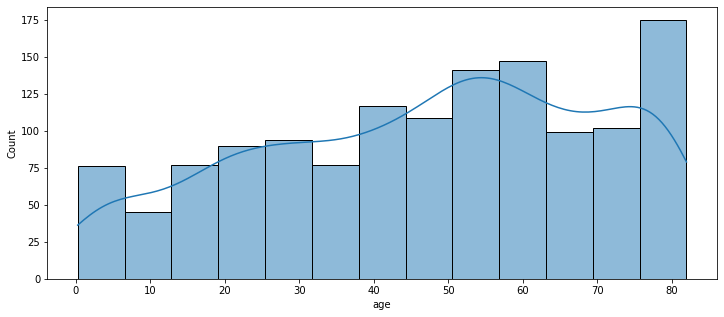

In [25]:
# plot the distribution of the column 'age'
plt.figure(figsize=(12, 5))
sns.histplot(df['age'], kde=True)
plt.show()

Afișăm un grafic pentru a vizualiza câte persoane au avut infarct și câte nu:

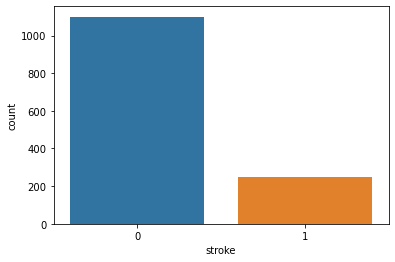

In [26]:
# plot a countplot diagram with stroke/not stroke numbers
sns.countplot(x='stroke', data=df)
plt.show()

Curățăm datele și ștergem coloana ”id”.

In [27]:
print("\nCLEANING THE DATA\n")

# drop irrelevant columns ('id')
df = df.drop("id", axis=1)


CLEANING THE DATA



Transformarea valorilor numerice String în tipul de date Float.

In [28]:
# cast columns containing numeric values (but provided as string) to float ('bmi')
df["bmi"] = df["bmi"].astype(float)

Ștergem liniile în care ”bmi” este null și ”smoking_status” este ”unknown”, iar dacă după mai există valori ale lui ”bmi” care sunt ”unknown” le înlocuim cu media de pe această coloană.

In [29]:
# remove the rows where bmi is null and smoking_status is unknown
df = df[(df["bmi"].notnull()) | (df["smoking_status"] != "Unknown")]

# if the bmi value is unknown, replace it with the mean value from that column
df["bmi"] = df["bmi"].fillna(df["bmi"].mean())

Transformăm coloanele de tip String în variabile categoriale:

In [30]:
# transform relevant columns containing string values into categorical variables
columns_to_transform = [
    "gender",
    "ever_married",
    "work_type",
    "Residence_type",
    "smoking_status"
]

df[columns_to_transform] = df[columns_to_transform].apply(lambda x: x.astype("category").cat.codes)


Separăm coloana pe care dorim să o prezicem:

In [31]:
# separate the characteristics of the target variable
X = df.drop("stroke", axis=1)
y = df["stroke"]

Împărțim datele în test și train.

In [32]:
# divide the dataset into train and test subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

Folosim MinMaxScaler pentru a normaliza datele.

In [33]:
# feature scaling
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

A fost folosit modelul de clasificare Sequential. 
Am afișat o rețea neuronală cu două straturi ce are 30 de neuroni la fiecare strat, folosind funcția de activare ReLU”.
Am folosit straturi de Dropout pentru a evita overfitting-ul. Pentru stratul de input ar trebui folosită o valoare între 0.5 și 0.8 pentru rezultate optime, iar valoarea optimă pentru stratul ascuns ar fi în jur de 0.5.
Pentru stratul de ieșire a fost folosită funcția de activare ”sigmoid”, deoarece este cel mai des folosită pentru clasificarea binară.

In [34]:
print("----CLASSIFICATION USING SEQUENTIAL MODEL----\n")

model = Sequential()
model.add(Dense(units=30, activation='relu', input_shape=(10,)))  # first layer
model.add(Dropout(0.6))  # used to avoid overfitting (input layer - best between 0.5 - 0.8)
model.add(Dense(units=30, activation='relu'))  # second layer
model.add(Dropout(0.5))  # used to avoid overfitting (hidden layer - best ~0.5)
model.add(Dense(units=1, activation='sigmoid'))  # output layer - use sigmoid because it is a binary classification
print(model.summary())

----CLASSIFICATION USING SEQUENTIAL MODEL----

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 30)                330       
                                                                 
 dropout (Dropout)           (None, 30)                0         
                                                                 
 dense_1 (Dense)             (None, 30)                930       
                                                                 
 dropout_1 (Dropout)         (None, 30)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 31        
                                                                 
Total params: 1,291
Trainable params: 1,291
Non-trainable params: 0
_________________________________________________________________
None


Compilăm modelul, folosind funcția de optimizare ”nadam”. S-a folosit EarlyStopping pentru a se evita overfitting-ul. Am antrenat modelul pentru 150 de epoci și observăm că modelul se oprește mai devreme din cauza folosirii funcției EarlyStopping.

In [35]:
model.compile(optimizer='nadam', loss='binary_crossentropy', metrics=['accuracy'])

# use EarlyStopping to avoid overfitting
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25)

history = model.fit(x=X_train,
                    y=y_train,
                    epochs=150,
                    validation_data=(X_test, y_test),
                    verbose=1,
                    callbacks=[early_stop]
                    )

Epoch 1/150
29/29 [==============================] - 1s 8ms/step - loss: 0.5862 - accuracy: 0.7603 - val_loss: 0.5679 - val_accuracy: 0.7985
Epoch 2/150
29/29 [==============================] - 0s 2ms/step - loss: 0.5403 - accuracy: 0.8132 - val_loss: 0.5384 - val_accuracy: 0.7985
Epoch 3/150
29/29 [==============================] - 0s 2ms/step - loss: 0.5307 - accuracy: 0.8272 - val_loss: 0.5278 - val_accuracy: 0.7985
Epoch 4/150
29/29 [==============================] - 0s 2ms/step - loss: 0.5142 - accuracy: 0.8315 - val_loss: 0.5187 - val_accuracy: 0.7985
Epoch 5/150
29/29 [==============================] - 0s 2ms/step - loss: 0.5142 - accuracy: 0.8348 - val_loss: 0.5114 - val_accuracy: 0.7985
Epoch 6/150
29/29 [==============================] - 0s 2ms/step - loss: 0.4863 - accuracy: 0.8305 - val_loss: 0.5039 - val_accuracy: 0.7985
Epoch 7/150
29/29 [==============================] - 0s 2ms/step - loss: 0.4863 - accuracy: 0.8348 - val_loss: 0.4983 - val_accuracy: 0.7985
Epoch 8/150
2

Afișăm raportul clasificării, afișând valorile precision, recall, f1-score atât pentru prezicerile valorii 0 (nu există infarct), cât și pentru prezicerea valorii 1 (există infarct). Acuratețea totală a modelul este de 0.8.

In [36]:
print("\nDISPLAY THE CLASSIFICATION REPORT\n")

y_pred = (model.predict(X_test) > 0.5).reshape((-1,))
print(classification_report(y_test, y_pred))


DISPLAY THE CLASSIFICATION REPORT

13/13 [==============================] - 0s 878us/step
              precision    recall  f1-score   support

           0       0.82      0.99      0.90       317
           1       0.86      0.15      0.26        80

    accuracy                           0.82       397
   macro avg       0.84      0.57      0.58       397
weighted avg       0.83      0.82      0.77       397

